In [1]:
from pathlib import Path

import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
class ApartmentDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self._features = torch.from_numpy(features).float()
        self._labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self._features)

    def __getitem__(self, idx):
        return self._features[idx], self._labels[idx]
    

class ApartmentDataModule(pl.LightningDataModule):
    def __init__(self, dataset: ApartmentDataset):
        super().__init__()
        self._dataset = dataset
        self._train_dataset = None
        self._val_dataset = None
        self._test_dataset = None
        
    def prepare_data(self):
        test_size = round(len(self._dataset) * 0.1)
        train_size = round((len(self._dataset) - test_size) * 0.85)
        self._test_dataset, rest = random_split(self._dataset, (test_size, len(self._dataset) - test_size), )
        self._train_dataset, self._val_dataset = random_split(rest, (train_size, len(rest) - train_size))
    
    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=512, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self._test_dataset, num_workers=12)
        

In [5]:
labels_to_names = {
    0: 'cheap',
    1: 'average',
    2: 'expensive'
}

In [6]:
import io

import torchvision
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from torchmetrics.classification import MulticlassConfusionMatrix
from pytorch_lightning.loggers import TensorBoardLogger

In [7]:
class ApartmentClassifier(pl.LightningModule):
    def __init__(
            self,
            input_size,
            output_size,
    ):
        super(ApartmentClassifier, self).__init__()

        self.l1 = nn.Linear(input_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 128)
        self.l5 = nn.Linear(128, 32)
        self.l6 = nn.Linear(32, output_size)
        
        self._cross_entropy_loss = torch.nn.CrossEntropyLoss(
            weight=torch.FloatTensor([2.5, 1, 4]).cuda()
        )
                
        self._accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
        self._accuracy_per_class = torchmetrics.classification.MulticlassAccuracy(num_classes=3, average='none').to(device)
        self._f1 = torchmetrics.classification.MulticlassF1Score(num_classes=3).to(device)
        self._f1_per_class = torchmetrics.classification.MulticlassF1Score(num_classes=3, average='none').to(device)
        
        # (predicted, actual)
        self._test_preds = None

    def forward(self, x: torch.Tensor):
        # todo batchnorm

        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        x = torch.relu(x)
        x = self.l4(x)
        x = torch.relu(x)
        x = self.l5(x)
        x = torch.relu(x)
        x = self.l6(x)
        return x.float()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
    
    def loss(self, logits, labels):
        return self._cross_entropy_loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
            
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        label = torch.argmax(y, dim=1)
        logits = self.forward(x)
        predicted = torch.argmax(logits, dim=1)
        
        loss = self.loss(logits, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        
        acc = self._accuracy(predicted, label)
        self.log('test_mean_acc', acc, on_step=False, on_epoch=True)
        acc_per_class = self._accuracy_per_class(predicted, label)
        self.log(f'test_acc_{label[0]}', acc_per_class[int(label[0])], on_step=False, on_epoch=True)
        
        f1 = self._f1(predicted, label)
        self.log('test_mean_f1', f1, on_step=False, on_epoch=True)
        f1_per_class = self._f1_per_class(predicted, label)
        self.log(f'test_f1_{label[0]}', f1_per_class[int(label[0])], on_step=False, on_epoch=True)
        
        self._test_preds.append((predicted, label))
        
        
    def on_test_start(self) -> None:
        self._test_preds = []
        
    def on_test_end(self) -> None:
        preds = torch.cat([p for p, _ in self._test_preds])
        labels = torch.cat([l for _, l in self._test_preds])
        confusion = MulticlassConfusionMatrix(num_classes=3, normalize='true').to(device)
        computed_confusion = confusion(preds, labels)
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.heatmap(computed_confusion.cpu().numpy(), annot=True, annot_kws={"size": 16}, ax=ax)
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        logger = self.logger
        assert isinstance(logger, TensorBoardLogger)
        logger.experiment.add_image("test_confusion_matrix", im)
        

In [8]:
import pandas as pd

In [9]:
TRAIN_DATA = Path('data/train_data.csv')

_df = pd.read_csv(TRAIN_DATA)
_df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [10]:
categorical_cols = [
    'HallwayType',
    'HeatingType',
    'AptManageType',
    'N_Parkinglot(Ground)',
    'N_Parkinglot(Basement)',
    'TimeToBusStop',
    'TimeToSubway',
    'SubwayStation',
]

df = pd.concat([_df.drop(columns=categorical_cols), *[pd.get_dummies(_df[col], prefix=col, dtype=int) for col in categorical_cols]], axis=1)
df

,SalePrice,YearBuilt,Size(sqf),Floor,N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),HallwayType_corridor,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,3.0,0.0,5,6.0,9.0,0,...,0,0,0,0,0,0,1,0,0,0
1,51327,1985,587,8,2.0,2.0,3,12.0,4.0,1,...,1,0,0,0,0,1,0,0,0,0
2,48672,1985,587,6,2.0,2.0,3,12.0,4.0,1,...,1,0,0,0,0,1,0,0,0,0
3,380530,2006,2056,8,5.0,11.0,5,3.0,7.0,0,...,0,0,0,0,0,0,0,0,1,0
4,78318,1992,644,2,4.0,8.0,3,9.0,14.0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,14.0,16.0,10,9.0,10.0,0,...,0,0,0,0,0,0,1,0,0,0
4120,307079,2015,644,22,5.0,10.0,7,7.0,11.0,0,...,1,0,0,0,0,1,0,0,0,0
4121,357522,2007,868,20,14.0,16.0,10,9.0,10.0,0,...,0,0,0,0,0,0,1,0,0,0
4122,312389,1978,1327,1,1.0,4.0,3,7.0,11.0,1,...,0,0,0,0,0,0,1,0,0,0


In [11]:
def price_to_class(price: int) -> int:
    return int(price > 350_000) + int(price > 100_000)

features = df.drop(columns=['SalePrice'])
labels = pd.get_dummies(df['SalePrice'].rename('class').apply(price_to_class))
labels

,0,1,2
0,False,True,False
1,True,False,False
2,True,False,False
3,False,False,True
4,True,False,False
...,...,...,...
4119,False,False,True
4120,False,True,False
4121,False,False,True
4122,False,True,False


In [12]:
dataset = ApartmentDataset(features=features.values, labels=labels.values)
data_module = ApartmentDataModule(dataset=dataset)

In [13]:
model = ApartmentClassifier(input_size=len(features.columns), output_size=3)

In [14]:
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=True)
trainer.fit(model, datamodule=data_module)

# `tensorboard --logdir=lightning_logs` to launch tensorboard

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params
------------------------------------------------------------
0  | l1                  | Linear             | 38.4 K
1  | l2                  | Linear             | 262 K 
2  | l3                  | Linear             | 131 K 
3  | l4                  | Linear             | 32.9 K
4  | l5                  | Linear             | 4.1 K 
5  | l6                  | Linear             | 99    
6  | _cross_entropy_loss | CrossEntropyLoss   | 0     
7  | _accuracy           | MulticlassAccuracy | 0     
8  | _accuracy_per_class | MulticlassAccuracy | 0     
9  | _f1                 | MulticlassF1Score  | 0     
10 | _f1_per_class       | MulticlassF1Score  | 0     
------------------------------------------------------------
469 K     Trainable par

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │    0.9545454382896423     │
│        test_acc_1         │    0.7508532404899597     │
│        test_acc_2         │            1.0            │
│         test_f1_0         │    0.9545454382896423     │
│         test_f1_1         │    0.7508532404899597     │
│         test_f1_2         │            1.0            │
│         test_loss         │    0.45786958932876587    │
│       test_mean_acc       │    0.8155339956283569     │
│       test_mean_f1        │    0.8155339956283569     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.45786958932876587,
  'test_mean_acc': 0.8155339956283569,
  'test_acc_1': 0.7508532404899597,
  'test_mean_f1': 0.8155339956283569,
  'test_f1_1': 0.7508532404899597,
  'test_acc_0': 0.9545454382896423,
  'test_f1_0': 0.9545454382896423,
  'test_acc_2': 1.0,
  'test_f1_2': 1.0}]

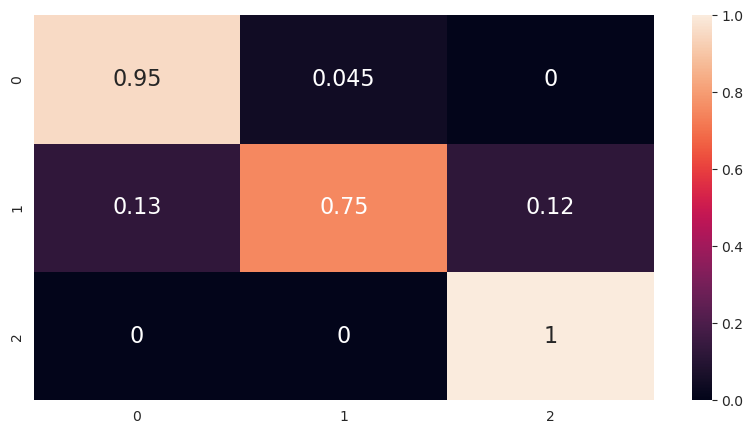

In [15]:
trainer.test(datamodule=data_module, ckpt_path='last')